In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math as m
#%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import q_stats

In [2]:
qstats=pd.read_csv('../data/qstats_for_M1')
qstats

,Unnamed: 0,content_id,bundle_id,correct_answer,part,tags,qstats_count,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation
0,0,0,0,0,1,51 131 162 38,6903,0.907721,0.948138,0.911994,0.829609
1,1,1,1,1,1,131 36 81,7398,0.890646,0.980400,0.892183,0.813793
2,2,2,2,0,1,131 101 162 92,44905,0.554281,0.888253,0.562213,0.491232
3,3,3,3,0,1,131 149 162 29,22973,0.779437,0.958473,0.783460,0.686583
4,4,4,4,3,1,131 5 162 38,31736,0.613215,0.530313,0.654308,0.566819
...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,13518,3,5,14,868,0.786866,0.998848,0.786621,1.000000
13519,13519,13519,13519,3,5,8,924,0.571429,0.994589,0.570185,0.800000
13520,13520,13520,13520,2,5,73,861,0.672474,0.995354,0.670945,1.000000
13521,13521,13521,13521,0,5,125,870,0.808046,0.996552,0.808535,0.666667


# Model import

In [3]:
import pickle
my_pipeline = pickle.load(open('../models/xgboost_pipe_M1.pkl',"rb"))  ## wb= write bites : le b est important

In [4]:
pipeline_features_list=pd.read_csv('../models/xgboost_pipe_M1_features_list')

In [5]:
[pipeline_features_list.feature.to_list()]

[['user_personalized_qstat_knowing_had_explanation_or_not',
  'user_avg_score_cum_on_this_part',
  'user_correct_answers_cum_on_this_part',
  'qstats_answered_correctly',
  'user_avg_score_cum',
  'qstats_prior_question_had_explanation',
  'already_seen',
  'user_activity_cumcount',
  'at_least_one_lesson']]

# Initialisation utilisateur débutant

In [6]:
user_history_empty=pd.DataFrame({#following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             'at_least_one_lesson':[0],
                             ### TO BE UPDATED IF LAST WAS QUESTION , ELSE COPIED ###
                             'user_avg_score_cum':[0.499],
                             'user_correct_answers_cum':[0],
                             'user_avg_score_cum_part1':[0.499],
                             'user_avg_score_cum_part2':[0.499],
                             'user_avg_score_cum_part3':[0.499],
                             'user_avg_score_cum_part4':[0.499],
                             'user_avg_score_cum_part5':[0.499],
                             'user_avg_score_cum_part6':[0.499],
                             'user_avg_score_cum_part7':[0.499],
                             'user_correct_answers_cum_part1':[0],
                             'user_correct_answers_cum_part2':[0],
                             'user_correct_answers_cum_part3':[0],
                             'user_correct_answers_cum_part4':[0],
                             'user_correct_answers_cum_part5':[0],
                             'user_correct_answers_cum_part6':[0],
                             'user_correct_answers_cum_part7':[0],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })

# User history step

## Update function

In [136]:
def user_history_update(content_type_id,
                        content_id,
                        data_qstats,
                        user_history=None,
                        mode='training',    #autre choix : mode exam
                        prior_question_had_explanation=False):
    '''Crée ou met à jour l'hisorique d'un utilisateur, stockée dans un df'''

    if not type(user_history)==pd.DataFrame:
        user_history=pd.DataFrame({
                             #following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             'mode':'n/a',
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             ### TO BE UPDATED IF LAST WAS LECTURE ###
                             'at_least_one_lesson':[0],
                             ### TO BE UPDATED IF LAST WAS QUESTION ###
                             'user_avg_score_cum':[0.499],
                             'user_correct_answers_cum':[0],
                             'user_avg_score_cum_part1':[0.499],
                             'user_avg_score_cum_part2':[0.499],
                             'user_avg_score_cum_part3':[0.499],
                             'user_avg_score_cum_part4':[0.499],
                             'user_avg_score_cum_part5':[0.499],
                             'user_avg_score_cum_part6':[0.499],
                             'user_avg_score_cum_part7':[0.499],
                             'user_correct_answers_cum_part1':[0],
                             'user_correct_answers_cum_part2':[0],
                             'user_correct_answers_cum_part3':[0],
                             'user_correct_answers_cum_part4':[0],
                             'user_correct_answers_cum_part5':[0],
                             'user_correct_answers_cum_part6':[0],
                             'user_correct_answers_cum_part7':[0],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED FROM QUESTIONS ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })
    

    last_line=user_history.iloc[-1]
    new_line =last_line.copy()
    
    last_content_type_id=user_history.iloc[-1]['content_type_id']
    
    ### TO BE IMPUTED ###
    new_line['content_id']=content_id
    new_line['content_type_id']=content_type_id
    new_line['prior_question_had_explanation']=prior_question_had_explanation
    new_line['mode']=mode
    ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
    new_line['user_activity_cumcount'] += 1
    
    if mode=='training':
        if last_content_type_id==0:
            part=last_line['part']
            ### TO BE UPDATED IF LAST WAS QUESTION ###
            new_line['user_correct_answers_cum'] = last_line['user_correct_answers_cum']\
                                                 + last_line['answered_correctly']
            new_user_questions_count             = last_line['user_correct_answers_cum']\
                                                 / (last_line['user_avg_score_cum']+0.000001)\
                                                 + 1
            new_line['user_avg_score_cum']       = new_line['user_correct_answers_cum']\
                                                 / (new_user_questions_count+0.000001)

            new_line[f'user_correct_answers_cum_part{part}'] = last_line[f'user_correct_answers_cum_part{part}']\
                                                             + last_line['answered_correctly']
            vars()[f'new_user_questions_count_part{part}']   = last_line[f'user_correct_answers_cum_part{part}']\
                                                             / (last_line[f'user_avg_score_cum_part{part}']+0.000001)\
                                                             + 1
            new_line[f'user_avg_score_cum_part{part}']       = new_line[f'user_correct_answers_cum_part{part}']\
                                                             / (vars()[f'new_user_questions_count_part{part}']+0.000001)

        elif last_content_type_id==1:
            ### TO BE UPDATED IF LAST WAS LECTURE ###
            new_line['at_least_one_lesson']=1
        
    if content_type_id==0:        
        currect_question_stats=qstats.loc[qstats.content_id==content_id].iloc[-1]
        ### TO BE IMPORTED FROM QUESTIONS ###
        new_line['part']\
              = currect_question_stats['part']
        new_line['qstats_answered_correctly']\
              = currect_question_stats['qstats_answered_correctly']
        new_line['qstats_prior_question_had_explanation']\
              = currect_question_stats['qstats_prior_question_had_explanation']
        new_line['qstats_answered_correctly_knowing_having_had_explanation']\
              = currect_question_stats['qstats_answered_correctly_knowing_having_had_explanation']
        new_line['qstats_answered_correctly_knowing_having_not_had_explanation']\
              = currect_question_stats['qstats_answered_correctly_knowing_having_not_had_explanation']
        ### TO BE COMPUTED ###
        new_line['user_personalized_qstat_knowing_had_explanation_or_not']\
              = new_line['qstats_answered_correctly_knowing_having_had_explanation']\
             if prior_question_had_explanation\
           else new_line['qstats_answered_correctly_knowing_having_not_had_explanation']
        new_line['already_seen']\
              = 1 if content_id in user_history.loc[user_history.content_type_id==0,'content_id']\
           else 0
        new_line['user_avg_score_cum_on_this_part']=new_line[f'user_avg_score_cum_part{new_line["part"]}']
        new_line['user_correct_answers_cum_on_this_part']=new_line[f'user_correct_answers_cum_part{new_line["part"]}']
                                              
    elif content_type_id==1:
        
        ### TO BE IMPORTED ###
        new_line['part']= -1 # TODO : si on veut utiliser la partie de la lecture, il faut importer la base des lectures
        new_line['qstats_answered_correctly']= -1
        new_line['qstats_prior_question_had_explanation']= -1
        new_line['qstats_answered_correctly_knowing_having_had_explanation']= -1
        new_line['qstats_answered_correctly_knowing_having_not_had_explanation']= -1
        ### TO BE COMPUTED ###
        new_line['user_personalized_qstat_knowing_had_explanation_or_not']= -1
        new_line['already_seen']= -1
        new_line['user_avg_score_cum_on_this_part']= -1
        new_line['user_correct_answers_cum_on_this_part']= -1
        
    ### TO BE PREDICTED ###
    new_line['answered_correctly']= -1
                                
    user_history=user_history.append(new_line,ignore_index=True)

    return user_history

## Test de la fonction

In [262]:
user_history=user_history_update(0, #content_type_id=0 <=> question
                                 13522, #numéro d'une question au hasard
                                 qstats, #df des stats questions
                                 user_history=None, #None pour une utilisateur nouveau
                                 prior_question_had_explanation=False, #
                                )
user_history.iloc[-1,-1]=0.8
user_history

,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.499,0,0.499,0.499,...,-1,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1,-1.000,-1,-1.0
1,13522,0,False,training,0,0,0.499,0,0.499,0.499,...,5,0.913953,0.99186,0.913247,1.0,1.0,0,0.499,0,0.8


In [21]:
user_history=user_history_update(0,13521,qstats,user_history,prior_question_had_explanation=False)
user_history

,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.499,0.0,0.499,0.499,...,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000,-1.0,-1.0
1,13522,0,False,training,0,0,0.499,0.0,0.499,0.499,...,5,0.913953,0.991860,0.913247,1.000000,1.000000,0,0.499,0.0,0.8
2,13521,0,False,training,1,0,0.800,0.8,0.499,0.499,...,5,0.808046,0.996552,0.808535,0.666667,0.666667,0,0.800,0.8,-1.0


## Loop

In [33]:
loop_length=100
question_selection_strategy='random'

import random

### Initialize the user to None or starting level ###
user_history=None

for i in range(loop_length):
    ### CHOIX DE LA QUESTION ###
    if question_selection_strategy=='random':
        next_question_id=random.choice(qstats.content_id.to_list())
    
    
    user_history=user_history_update(0,
                                     next_question_id,
                                     qstats,
                                     user_history,
                                     mode='training',
                                     prior_question_had_explanation=random.uniform(0, 1)>0.1)
    
    ### PREDICTION ###
    user_history.iloc[-1,-1]\
        = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
user_history
    

,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.499000,0.000000,0.499000,0.499000,...,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.000000,-1.000000
1,10156,0,True,training,0,0,0.499000,0.000000,0.499000,0.499000,...,6,0.935778,0.964371,0.934803,0.962185,0.934803,0,0.499000,0.000000,0.070943
2,7256,0,True,training,1,0,0.070943,0.070943,0.499000,0.499000,...,7,0.939275,0.955876,0.936472,1.000000,0.936472,0,0.499000,0.000000,0.897830
3,12280,0,True,training,2,0,0.484386,0.968773,0.499000,0.499000,...,3,0.900794,0.980159,0.898785,1.000000,0.898785,0,0.499000,0.000000,0.866527
4,5319,0,True,training,3,0,0.611767,1.835300,0.499000,0.499000,...,5,0.753854,0.324473,0.831240,0.716684,0.831240,0,0.499000,0.000000,0.857180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1983,0,False,training,95,0,0.689225,65.476328,0.755667,0.622827,...,3,0.681965,0.968469,0.682068,0.678815,0.678815,0,0.672725,7.399975,0.796632
97,2274,0,True,training,96,0,0.690343,66.272960,0.755667,0.622827,...,3,0.641673,0.971992,0.640651,0.677130,0.640651,0,0.683051,8.196607,0.698220
98,4186,0,True,training,97,0,0.690425,66.971180,0.755667,0.622827,...,5,0.948855,0.942748,0.953036,0.880000,0.953036,0,0.721749,30.313461,0.672461
99,4575,0,True,training,98,0,0.690241,67.643641,0.755667,0.622827,...,5,0.771135,0.851495,0.797282,0.621212,0.797282,0,0.720603,30.985922,0.976701


# Looping functions

## Training

In [269]:
def training (my_pipeline,
              pipeline_features_list,
              qstats,
              qselection_by_part_and_level=None,
              user_history=None,
              loop_length=30,
              question_selection_strategy='random'):
    '''only the random and knowledge_tracing strategies implemented yet'''
    number_of_questions_seen_in_train=len(user_history.query('mode=="training"'))
    for i in range(loop_length):
        ### CHOIX DE LA QUESTION ###
        next_question_id=pick_a_question(qstats,
                                         qselection_by_part_and_level,
                                         user_history.iloc[-1],
                                         strategy=question_selection_strategy,
                                         number_of_questions_seen=number_of_questions_seen_in_train)


        user_history=user_history_update(0,
                                         next_question_id,
                                         qstats,
                                         user_history,
                                         mode='training',
                                         prior_question_had_explanation=random.uniform(0, 1)>0.1)
        
        number_of_questions_seen_in_train+=1

        ### PREDICTION ###
        user_history.iloc[-1,-1]\
                = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
    return user_history

## Final exam

In [208]:
def TOEIC_scoring (my_pipeline,
                   pipeline_features_list,
                   qstats, 
                   user_history,
                   number_of_questions=100,
                   TOEIC_strategy='random'):
    '''only the random strategy implemented yet'''
    
    for i in range(number_of_questions):
        ### CHOIX DE LA QUESTION ###
        if TOEIC_strategy=='random':
            next_question_id=random.choice(qstats.content_id.to_list())


        user_history=user_history_update(0,
                                         next_question_id,
                                         qstats,
                                         user_history,
                                         mode='exam',
                                         prior_question_had_explanation=False)

        ### PREDICTION ###
    user_history.iloc[-number_of_questions:,-1]\
            = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-number_of_questions:])[:,1]
    
    return user_history.iloc[-number_of_questions:].answered_correctly.mean()

In [14]:
user=initialize_profile([1,1,1,1,1,1,1])


,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.330136,109.7,0.3697,0.35535,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [23]:
TOEIC_scoring (my_pipeline,
               pipeline_features_list,
               qstats,
               user,
               number_of_questions=100,
               TOEIC_strategy='random')

0.5738580564233122

In [24]:
TOEIC_scoring2 (my_pipeline,
               pipeline_features_list,
               qstats,
               user,
               number_of_questions=100,
               TOEIC_strategy='random')

0.5327795481404928

In [209]:
def TOEIC_scoring2 (my_pipeline,
                   pipeline_features_list,
                   qstats, user_history,
                   number_of_questions=100,
                   TOEIC_strategy='random'):
    '''only the random strategy implemented yet'''
    
    for i in range(number_of_questions):
        ### CHOIX DE LA QUESTION ###
        if TOEIC_strategy=='random':
            next_question_id=random.choice(qstats.content_id.to_list())


        user_history=user_history_update(0,
                                         next_question_id,
                                         qstats,
                                         user_history,
                                         mode='exam',
                                         prior_question_had_explanation=False)

        ### PREDICTION ###
        user_history.iloc[-1,-1]\
            = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
    
    return user_history.iloc[-number_of_questions:].answered_correctly.mean()

In [34]:
TOEIC_scoring(qstats, user_history)

0.7035000891559166

In [36]:
user_history=None
TOEIC_scoring(qstats, user_history)

0.5785637135444083

# Profiles initialization

In [4]:
df = pd.read_csv('../data/train_1M_with_features_merged_v3.csv')

In [16]:
df

,Unnamed: 0,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,part2,part3,part4,part5,part6,part7,already_seen_tag_q_l_cumcount_with_trim_at_3,same_user_and_similar_to_prior,similar_to_prior_and_had_answered_correctly,similar_to_prior_and_have_had_explanation
0,0,90286654,0,1917429896,7900,0,0,1,NaN,0,...,0,0,0,0,0,0,0,0.0,-0.0,0.0
1,1,90286655,26511,1917429896,7876,0,1,0,21000.0,0,...,0,0,0,0,0,0,0,0.5,0.5,0.0
2,2,90286656,55312,1917429896,175,0,2,0,21000.0,0,...,0,0,0,0,0,0,0,0.5,0.0,0.0
3,3,90286657,102436,1917429896,1278,0,3,0,23000.0,0,...,1,0,0,0,0,0,0,0.0,0.0,0.0
4,4,90286658,188454,1917429896,2063,0,4,0,45000.0,0,...,0,1,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987264,987264,47484293,1619704,1003849974,6909,0,14,1,17000.0,0,...,0,0,0,0,1,0,0,0.5,0.5,0.0
987265,987265,47484294,1906094,1003849974,7217,0,15,1,68500.0,0,...,0,0,0,0,0,1,0,0.0,0.0,0.0
987266,987266,47484295,1906094,1003849974,7216,0,15,1,68500.0,0,...,0,0,0,0,0,1,0,0.5,0.5,0.0
987267,987267,47484296,1906094,1003849974,7219,0,15,1,68500.0,0,...,0,0,0,0,0,1,0,0.5,0.5,0.0


In [20]:
part1_mean_perf=df.query('content_type_id==0').query('part1==1').mean()['answered_correctly']
part2_mean_perf=df.query('content_type_id==0').query('part2==1').mean()['answered_correctly']
part3_mean_perf=df.query('content_type_id==0').query('part3==1').mean()['answered_correctly']
part4_mean_perf=df.query('content_type_id==0').query('part4==1').mean()['answered_correctly']
part5_mean_perf=df.query('content_type_id==0').query('part5==1').mean()['answered_correctly']
part6_mean_perf=df.query('content_type_id==0').query('part6==1').mean()['answered_correctly']
part7_mean_perf=df.query('content_type_id==0').query('part7==1').mean()['answered_correctly']

In [31]:
parts_mean_correct_count=[]
parts_max_correct_count=[]
for i in range(7):
    parts_mean_correct_count.append(df.query('content_type_id==0')\
                                    .query(f'part{i+1}==1')\
                                    .groupby('user_id')\
                                    .sum()['answered_correctly']\
                                    .mean())
    parts_max_correct_count.append(df.query('content_type_id==0')\
                                   .query(f'part{i+1}==1')\
                                   .groupby('user_id')\
                                   .sum()['answered_correctly']\
                                   .max())

In [34]:
parts_max_correct_count

[689, 2653, 1247, 981, 3561, 1363, 1012]

In [26]:
parts_mean_perfs=[]
for i in range(7):
    parts_mean_perfs.append([vars()[f'part{i+1}_mean_perf']])
parts_mean_perfs

[[0.7394397023418691],
 [0.7107757984490843],
 [0.6947983774755428],
 [0.6184897300138936],
 [0.6121735463434248],
 [0.6767750892502975],
 [0.6657133571660708]]

In [27]:
[lis[0] for lis in parts_mean_perfs]

[0.7394397023418691,
 0.7107757984490843,
 0.6947983774755428,
 0.6184897300138936,
 0.6121735463434248,
 0.6767750892502975,
 0.6657133571660708]

In [239]:
def initialize_profile(experience_list):
    '''Takes a list of 7 values, one per part
            0=full beginner,
            1=intermediate,
            2=average,
            3=fluent
            exemple : [0,1,1,3,1,2,0]
            
        Returns a one-line user_history 
        with the average and cumulated score per part initialized
            '''
    parts_mean_perfs=[0.7394,
                      0.7107,
                      0.6947,
                      0.6184,
                      0.6121,
                      0.6767,
                      0.6657]
    
    parts_mean_correct_count=[18.8,
                              35.0,
                              27.4,
                              24.3,
                              65.2,
                              32.6,
                              16.1]
    parts_max_correct_count=[689,
                             2653,
                             1247,
                             981,
                             3561,
                             1363,
                             1012]     
    
    user_avg_score_cum_parts=[]
    user_correct_answers_cum_parts=[]
    for i in range(7):
        if experience_list[i]==0:
            user_avg_score_cum_parts.append(0)
            user_correct_answers_cum_parts.append(0)
            at_least_one_lesson=0
        if experience_list[i]==1:
            user_avg_score_cum_parts.append(parts_mean_perfs[i]/3)
            user_correct_answers_cum_parts.append(parts_mean_correct_count[i]/3)
            at_least_one_lesson=0
        if experience_list[i]==2:
            user_avg_score_cum_parts.append(parts_mean_perfs[i]*2/3)
            user_correct_answers_cum_parts.append(parts_mean_correct_count[i]*2/3)
            at_least_one_lesson=1
        if experience_list[i]==3:
            user_avg_score_cum_parts.append(1)
            user_correct_answers_cum_parts.append(parts_max_correct_count[i])
            at_least_one_lesson=1
            
    user_correct_answers_cum=sum(user_correct_answers_cum_parts)
    user_avg_score_cum=user_correct_answers_cum\
                       /(sum([user_correct_answers_cum_parts[i]\
                              /(user_avg_score_cum_parts[i]+0.000001) for i in range(7)])+0.000001)
            
            
    user_profile=pd.DataFrame({
                             #following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             'mode':'n/a',
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             ### TO BE UPDATED IF LAST WAS LECTURE ###
                             'at_least_one_lesson':[at_least_one_lesson],
                             ### TO BE UPDATED IF LAST WAS QUESTION ###
                             'user_avg_score_cum':[user_avg_score_cum],
                             'user_correct_answers_cum':[user_correct_answers_cum],
                             'user_avg_score_cum_part1':[user_avg_score_cum_parts[0]],
                             'user_avg_score_cum_part2':[user_avg_score_cum_parts[1]],
                             'user_avg_score_cum_part3':[user_avg_score_cum_parts[2]],
                             'user_avg_score_cum_part4':[user_avg_score_cum_parts[3]],
                             'user_avg_score_cum_part5':[user_avg_score_cum_parts[4]],
                             'user_avg_score_cum_part6':[user_avg_score_cum_parts[5]],
                             'user_avg_score_cum_part7':[user_avg_score_cum_parts[6]],
                             'user_correct_answers_cum_part1':[user_correct_answers_cum_parts[0]],
                             'user_correct_answers_cum_part2':[user_correct_answers_cum_parts[1]],
                             'user_correct_answers_cum_part3':[user_correct_answers_cum_parts[2]],
                             'user_correct_answers_cum_part4':[user_correct_answers_cum_parts[3]],
                             'user_correct_answers_cum_part5':[user_correct_answers_cum_parts[4]],
                             'user_correct_answers_cum_part6':[user_correct_answers_cum_parts[5]],
                             'user_correct_answers_cum_part7':[user_correct_answers_cum_parts[6]],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED FROM QUESTIONS ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })
    return user_profile

In [5]:
initialize_profile([0,3,0,0,3,0,0]).loc[0]

content_id                                                         -1
content_type_id                                                    -1
prior_question_had_explanation                                  False
mode                                                              n/a
user_activity_cumcount                                             -1
at_least_one_lesson                                                 0
user_avg_score_cum                                                  1
user_correct_answers_cum                                         6214
user_avg_score_cum_part1                                            0
user_avg_score_cum_part2                                            1
user_avg_score_cum_part3                                            0
user_avg_score_cum_part4                                            0
user_avg_score_cum_part5                                            1
user_avg_score_cum_part6                                            0
user_avg_score_cum_p

In [ ]:
import math as

## Typical profiles

In [283]:
profiles={'beginner':[0,0,0,0,0,0,0],
          'lozere':[0,0,3,3,3,0,0],
          'lozerebis':[0,0,0,2,2,0,0],
          'lozere3':[0,0,0,1,1,0,0],
          'god':[3,3,3,3,3,3,3],
          'intermediate':[1,1,1,1,1,1,1],
          'lozere4':[2,2,2,2,0,0,2],
          'shuffle':[3,2,3,1,0,2,0],
         }

# Plot learning curve

In [205]:
def plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=5,
                        training_batch_size=10,
                        number_of_training_batches=10,
                        training_question_selection_strategy='random'):

    ### IF STRATEGY==knowledge_tracing, we make a selection of 7*4 lists of 50 questions for each part/level 
    qselection_by_part_and_level=[]
    strategies_using_preselected_questions=['knowledge_tracing',
                                            'sadic_coach',
                                            'textbook']
    if training_question_selection_strategy in strategies_using_preselected_questions:

        for i in range(7):
            questios=qstats.loc[qstats.part==i+1,['qstats_answered_correctly','content_id']].sort_values('qstats_answered_correctly',ascending=False)
            number_of_questions=len(questios)
            list0=questios.iloc[:50].content_id.to_list()
            tiers=int(number_of_questions/3)
            list1=questios.iloc[tiers-25:tiers+25].content_id.to_list()
            list2=questios.iloc[2*tiers-25:2*tiers+25].content_id.to_list()
            list3=questios.iloc[-50:].content_id.to_list()
            qselection_by_part_and_level.append([list0,list1,list2,list3])
        qselection_by_part_and_level=np.array(qselection_by_part_and_level)

    result_moy=[]

    for i in range(number_students):
        print(f'début essai {i+1}/{number_students}')
        results=[]
        training_questions=[]

        user_history=initialize_profile(initial_experience)
        
        results.append(TOEIC_scoring(my_pipeline,
                                     pipeline_features_list,
                                     qstats,
                                     user_history))
        training_questions.append(0)

        for j in range(number_of_training_batches):
            training_questions.append(training_questions[-1]+training_batch_size)
            #print(f'entrainement {j*training_batch_size}/{training_batch_size*number_of_training_batches}')

            user_history=training (my_pipeline,
                                   pipeline_features_list,
                                   qstats,
                                   qselection_by_part_and_level,
                                   user_history,
                                   loop_length=training_batch_size,
                                   question_selection_strategy=training_question_selection_strategy)
            results.append(TOEIC_scoring(my_pipeline,
                                         pipeline_features_list,
                                         qstats, 
                                         user_history))

        result_moy.append(results)
    stats=np.array(result_moy)
    return pd.DataFrame({'training_questions':training_questions,'TOEIC_score':stats.mean(axis=0)}).set_index('training_questions')

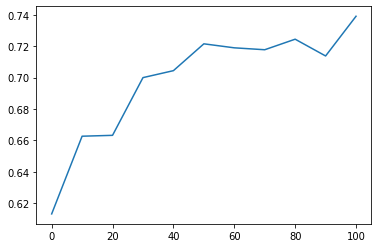

In [38]:
stats=np.array(result_moy)
plt.plot(training_questions,stats.mean(axis=0))

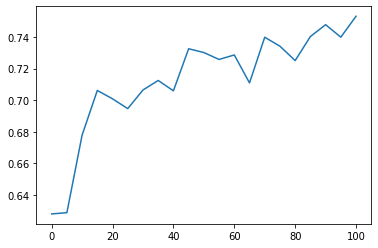

# Import des fonctions py

In [7]:
from tm_loop_functions import *

In [9]:
random_trained_beginners= plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')

début essai 1/10
entrainement 0/100
entrainement 5/100
entrainement 10/100
entrainement 15/100
entrainement 20/100
entrainement 25/100
entrainement 30/100
entrainement 35/100
entrainement 40/100
entrainement 45/100
entrainement 50/100
entrainement 55/100
entrainement 60/100
entrainement 65/100
entrainement 70/100
entrainement 75/100
entrainement 80/100
entrainement 85/100
entrainement 90/100
entrainement 95/100
début essai 2/10
entrainement 0/100
entrainement 5/100
entrainement 10/100
entrainement 15/100
entrainement 20/100
entrainement 25/100
entrainement 30/100
entrainement 35/100
entrainement 40/100
entrainement 45/100
entrainement 50/100
entrainement 55/100
entrainement 60/100
entrainement 65/100
entrainement 70/100
entrainement 75/100
entrainement 80/100
entrainement 85/100
entrainement 90/100
entrainement 95/100
début essai 3/10
entrainement 0/100
entrainement 5/100
entrainement 10/100
entrainement 15/100
entrainement 20/100
entrainement 25/100
entrainement 30/100
entrainement 35

In [13]:
print(random_trained_beginners)

                    TOEIC_score
training_questions             
0                      0.463235
5                      0.569529
10                     0.625405
15                     0.632695
20                     0.678593
25                     0.664312
30                     0.675168
35                     0.690843
40                     0.691366
45                     0.687350
50                     0.690604
55                     0.703092
60                     0.696978
65                     0.709846
70                     0.696086
75                     0.733497
80                     0.711560
85                     0.715125
90                     0.713610
95                     0.717022
100                    0.707405


<AxesSubplot:xlabel='training_questions'>

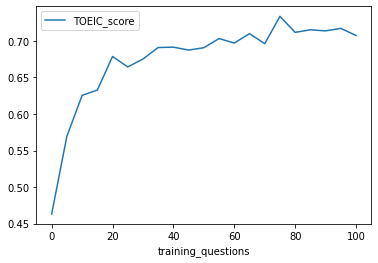

In [11]:
random_trained_beginners.plot()

In [ ]:
test= plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=1,
                        training_batch_size=5,
                        number_of_training_batches=2,
                        training_question_selection_strategy='random')

# Picking questions

In [56]:
level=3
user=initialize_profile([level,level,level,level,level,level,level])

In [104]:
level=3
user=initialize_profile([level,level,level,level,1,level,level])

In [105]:
last_line=user.iloc[-1]
last_line

content_id                                                           -1
content_type_id                                                      -1
prior_question_had_explanation                                    False
mode                                                                n/a
user_activity_cumcount                                               -1
at_least_one_lesson                                                   1
user_avg_score_cum                                              0.99082
user_correct_answers_cum                                         7977.6
user_avg_score_cum_part1                                              1
user_avg_score_cum_part2                                              1
user_avg_score_cum_part3                                              1
user_avg_score_cum_part4                                              1
user_avg_score_cum_part5                                        0.30605
user_avg_score_cum_part6                                        

In [281]:
def pick_a_question(qstats,
                    qselection_by_part_and_level,
                    user_history_last_line,
                    strategy='random',
                    number_of_questions_seen=0):
    import math as m
    if strategy=='random':
        question_id=random.choice(qstats.content_id.to_list())

    elif strategy=='sadic_coach':
        competences=[]
        for i in range(7):
            competences.append(user_history_last_line[f'user_avg_score_cum_part{i+1}']\
                              *m.sqrt(user_history_last_line[f'user_correct_answers_cum_part{i+1}']))
        weakest_part=np.argmin(competences)+1
        weakest_value=min(competences)

        weakest_level=3
        if weakest_value > 0.5:
            weakest_level=2
        if weakest_value > 2.4:
            weakest_level=1
        if weakest_value > 11:
            weakest_level=0

        question_id=random.choice(qselection_by_part_and_level[weakest_part-1,weakest_level])

        #question_id=random.choice(qstats.content_id.to_list())

    elif strategy=='knowledge_tracing':
        competences=[]
        for i in range(7):
            competences.append(user_history_last_line[f'user_avg_score_cum_part{i+1}']\
                              *m.sqrt(user_history_last_line[f'user_correct_answers_cum_part{i+1}']))
        weakest_part=np.argmin(competences)+1
        weakest_value=min(competences)

        weakest_level=0
        if weakest_value > 0.5:
            weakest_level=1
        if weakest_value > 2.4:
            weakest_level=2
        if weakest_value > 11:
            weakest_level=3

        question_id=random.choice(qselection_by_part_and_level[weakest_part-1,weakest_level])

        #question_id=random.choice(qstats.content_id.to_list())    
    
    elif strategy=='textbook':
        level=int(number_of_questions_seen/49)
        part=int((number_of_questions_seen-level*49)/7)+1
        question_id=random.choice(qselection_by_part_and_level[part-1,level])
        
    else:
        question_id=-1
    #print(question_id)
    return question_id

In [151]:
last_line

content_id                                                           -1
content_type_id                                                      -1
prior_question_had_explanation                                    False
mode                                                                n/a
user_activity_cumcount                                               -1
at_least_one_lesson                                                   1
user_avg_score_cum                                              0.99082
user_correct_answers_cum                                         7977.6
user_avg_score_cum_part1                                              1
user_avg_score_cum_part2                                              1
user_avg_score_cum_part3                                              1
user_avg_score_cum_part4                                              1
user_avg_score_cum_part5                                        0.30605
user_avg_score_cum_part6                                        

In [150]:
num=pick_a_question(qstats,
                qlists_by_part_and_level,
                last_line,
                strategy='knowledge_tracing')
num

6307

In [93]:
last_line

content_id                                                         -1
content_type_id                                                    -1
prior_question_had_explanation                                  False
mode                                                              n/a
user_activity_cumcount                                             -1
at_least_one_lesson                                                 1
user_avg_score_cum                                                  1
user_correct_answers_cum                                         7945
user_avg_score_cum_part1                                            1
user_avg_score_cum_part2                                            1
user_avg_score_cum_part3                                            1
user_avg_score_cum_part4                                            1
user_avg_score_cum_part5                                            0
user_avg_score_cum_part6                                            1
user_avg_score_cum_p

In [152]:
qstats.loc[num]

Unnamed: 0                                                          6307
content_id                                                          6307
bundle_id                                                           6307
correct_answer                                                         2
part                                                                   5
tags                                                                  73
qstats_count                                                        5374
qstats_answered_correctly                                       0.612207
qstats_prior_question_had_explanation                           0.835876
qstats_answered_correctly_knowing_having_had_explanation        0.677427
qstats_answered_correctly_knowing_having_not_had_explanation    0.280045
Name: 6307, dtype: object

In [37]:
liss=[4,5,5,8,2,7]
index_min = np.argmin(liss)
index_min

4

In [64]:
number_of_questions=[]
for i in range(7):
    number_of_questions.append(len(qstats.loc[qstats.part==i+1]))
number_of_questions
    

[992, 1647, 1562, 1439, 5511, 1212, 1160]

In [63]:
qstats.query('part==1').sort_values('qstats_answered_correctly')

,Unnamed: 0,content_id,bundle_id,correct_answer,part,tags,qstats_count,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation
12812,12812,12812,12812,1,1,131 68 29,157,0.242038,0.968153,0.230263,0.600000
74,74,74,74,0,1,9 10 38,4345,0.269045,0.929804,0.265099,0.321311
12705,12705,12705,12705,2,1,61 110 81,194,0.283505,0.979381,0.289474,0.000000
12600,12600,12600,12600,0,1,61 110 81,176,0.284091,0.988636,0.287356,0.000000
12682,12682,12682,12682,2,1,10 178 81,173,0.300578,0.994220,0.296512,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
12745,12745,12745,12745,3,1,131 111 29,185,0.994595,0.989189,0.994536,1.000000
12806,12806,12806,12806,2,1,131 149 29,140,1.000000,1.000000,1.000000,1.000000
12615,12615,12615,12615,0,1,131 104 38,148,1.000000,0.986486,1.000000,1.000000
12809,12809,12809,12809,0,1,131 101 29,148,1.000000,0.972973,1.000000,1.000000


In [70]:
qlists_by_part_and_level=[]
for i in range(7):
    questios=qstats.loc[qstats.part==i+1,['qstats_answered_correctly','content_id']].sort_values('qstats_answered_correctly')
    number_of_questions=len(questios)
    list0=questios.iloc[:50].content_id.to_list()
    tiers=int(number_of_questions/3)
    list1=questios.iloc[tiers-25:tiers+25].content_id.to_list()
    list2=questios.iloc[2*tiers-25:2*tiers+25].content_id.to_list()
    list3=questios.iloc[50:].content_id.to_list()
    qlists_by_part_and_level.append([list0,list1,list2,list3])
qlists_by_part_and_level=np.array(qlists_by_part_and_level)
qlists_by_part_and_level.shape

(7, 4)

In [76]:
qselection_by_part_and_level=[]
for i in range(7):
    questios=qstats.loc[qstats.part==i+1,['qstats_answered_correctly','content_id']].sort_values('qstats_answered_correctly')
    number_of_questions=len(questios)
    list0=questios.iloc[:50].content_id.to_list()
    tiers=int(number_of_questions/3)
    list1=questios.iloc[tiers-25:tiers+25].content_id.to_list()
    list2=questios.iloc[2*tiers-25:2*tiers+25].content_id.to_list()
    list3=questios.iloc[50:].content_id.to_list()
    qselection_by_part_and_level.append([list0,list1,list2,list3])
qselection_by_part_and_level=np.array(qselection_by_part_and_level)
qlists_by_part_and_level.shape

(7, 4)

In [77]:
qlists_by_part_and_level[4,2]

[4339,
 9690,
 3605,
 11361,
 9497,
 5453,
 9188,
 4918,
 6241,
 9072,
 4444,
 4307,
 9886,
 3937,
 4288,
 5234,
 9704,
 8578,
 3662,
 4019,
 4448,
 8171,
 9281,
 8199,
 13465,
 5469,
 4416,
 4881,
 5532,
 3609,
 4404,
 8941,
 4356,
 5356,
 4570,
 9343,
 11237,
 5136,
 6139,
 11306,
 9401,
 9294,
 8765,
 4742,
 6175,
 9032,
 4885,
 3667,
 4552,
 5319]

In [176]:
df_beginners_knowledge_t=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='knowledge_tracing')
df_beginners_knowledge_t

début essai 1/10
entrainement 0/100
12805
user cum experience :  2
user avg correct :  0.0
10451
user cum experience :  3
user avg correct :  0.06940343348286145
12132
user cum experience :  4
user avg correct :  0.5334751291594848
12104
user cum experience :  5
user avg correct :  0.6880673611370962
12348
user cum experience :  6
user avg correct :  0.7478978507304064
entrainement 5/100
1668
user cum experience :  7
user avg correct :  0.7927450580241501
12438
user cum experience :  8
user avg correct :  0.8211024208117691
3089
user cum experience :  9
user avg correct :  0.8430130279374821
4042
user cum experience :  10
user avg correct :  0.8622443862056319
13379
user cum experience :  11
user avg correct :  0.8772583833108163
entrainement 10/100
11006
user cum experience :  12
user avg correct :  0.8851164913501388
11117
user cum experience :  13
user avg correct :  0.893155226420818
8098
user cum experience :  14
user avg correct :  0.898191741900431
6955
user cum experience :  15

user cum experience :  16
user avg correct :  0.9086454959919457
entrainement 15/100
12626
user cum experience :  17
user avg correct :  0.9130168336207476
10639
user cum experience :  18
user avg correct :  0.9183864186097308
6625
user cum experience :  19
user avg correct :  0.9221633881292911
11146
user cum experience :  20
user avg correct :  0.9230010229667859
2369
user cum experience :  21
user avg correct :  0.9189758358643833
entrainement 20/100
2139
user cum experience :  22
user avg correct :  0.916023402393954
7030
user cum experience :  23
user avg correct :  0.9154176209495283
6986
user cum experience :  24
user avg correct :  0.9149709582959248
5234
user cum experience :  25
user avg correct :  0.9144180672031293
8941
user cum experience :  26
user avg correct :  0.9144484326779798
entrainement 25/100
563
user cum experience :  27
user avg correct :  0.9122812472300021
980
user cum experience :  28
user avg correct :  0.9106300102601348
2816
user cum experience :  29
user

entrainement 25/100
1647
user cum experience :  27
user avg correct :  0.9128346013030044
2380
user cum experience :  28
user avg correct :  0.9161412379459093
11169
user cum experience :  29
user avg correct :  0.9165139683286706
11127
user cum experience :  30
user avg correct :  0.916924024331459
12859
user cum experience :  31
user avg correct :  0.9164773294897893
entrainement 30/100
10592
user cum experience :  32
user avg correct :  0.9162349475375235
8049
user cum experience :  33
user avg correct :  0.9176257916959522
7822
user cum experience :  34
user avg correct :  0.9190061593652327
3937
user cum experience :  35
user avg correct :  0.9194401964411897
4019
user cum experience :  36
user avg correct :  0.9202440763020586
entrainement 35/100
10117
user cum experience :  37
user avg correct :  0.9199007524171021
3323
user cum experience :  38
user avg correct :  0.9195117639628496
11622
user cum experience :  39
user avg correct :  0.9207487353205814
6747
user cum experience 

11076
user cum experience :  41
user avg correct :  0.9234049318186138
entrainement 40/100
11127
user cum experience :  42
user avg correct :  0.9230256245463417
2622
user cum experience :  43
user avg correct :  0.923298188451541
3276
user cum experience :  44
user avg correct :  0.9235577969247132
12903
user cum experience :  45
user avg correct :  0.9243788985804529
12628
user cum experience :  46
user avg correct :  0.9251131596479606
entrainement 45/100
980
user cum experience :  47
user avg correct :  0.9260274492987746
703
user cum experience :  48
user avg correct :  0.9269006994221193
7620
user cum experience :  49
user avg correct :  0.9269885141908412
7535
user cum experience :  50
user avg correct :  0.9273276662653505
9188
user cum experience :  51
user avg correct :  0.9277385153345251
entrainement 50/100
3605
user cum experience :  52
user avg correct :  0.9278117663898255
2519
user cum experience :  53
user avg correct :  0.9274055252839715
1533
user cum experience :  5

entrainement 50/100
8072
user cum experience :  52
user avg correct :  0.9230904490822599
8199
user cum experience :  53
user avg correct :  0.9233193958521128
5319
user cum experience :  54
user avg correct :  0.9237836847499244
12976
user cum experience :  55
user avg correct :  0.9232805272463437
1533
user cum experience :  56
user avg correct :  0.9236475150114927
entrainement 55/100
11794
user cum experience :  57
user avg correct :  0.9242942925881273
3459
user cum experience :  58
user avg correct :  0.9248313310649942
10374
user cum experience :  59
user avg correct :  0.9251970907965686
11157
user cum experience :  60
user avg correct :  0.9258450631933112
10654
user cum experience :  61
user avg correct :  0.9260565425161645
entrainement 60/100
7902
user cum experience :  62
user avg correct :  0.9262752318229845
630
user cum experience :  63
user avg correct :  0.9270194034345448
12013
user cum experience :  64
user avg correct :  0.9277624837548972
11650
user cum experience

572
user cum experience :  65
user avg correct :  0.9260296868729985
532
user cum experience :  66
user avg correct :  0.9254802592342184
entrainement 65/100
13081
user cum experience :  67
user avg correct :  0.9250510890366949
10129
user cum experience :  68
user avg correct :  0.9251727220223734
10843
user cum experience :  69
user avg correct :  0.9243985202063498
6581
user cum experience :  70
user avg correct :  0.9235738123572544
7451
user cum experience :  71
user avg correct :  0.9228378089475611
entrainement 70/100
7391
user cum experience :  72
user avg correct :  0.9217957923506948
8157
user cum experience :  73
user avg correct :  0.920937664289762
12589
user cum experience :  74
user avg correct :  0.9200639235201318
12846
user cum experience :  75
user avg correct :  0.9195391890462608
2144
user cum experience :  76
user avg correct :  0.9196935491659204
entrainement 75/100
1548
user cum experience :  77
user avg correct :  0.9198438063477322
4535
user cum experience :  

user cum experience :  76
user avg correct :  0.9183319596978359
entrainement 75/100
11650
user cum experience :  77
user avg correct :  0.9173604503231811
6973
user cum experience :  78
user avg correct :  0.916568974293116
6753
user cum experience :  79
user avg correct :  0.9159953176568136
6927
user cum experience :  80
user avg correct :  0.9155298304346843
9666
user cum experience :  81
user avg correct :  0.9151225201398913
entrainement 80/100
4074
user cum experience :  82
user avg correct :  0.914559350919014
11613
user cum experience :  83
user avg correct :  0.9139835456200396
2931
user cum experience :  84
user avg correct :  0.9132136833101899
2032
user cum experience :  85
user avg correct :  0.9129163515440792
2212
user cum experience :  86
user avg correct :  0.9126721800668673
entrainement 85/100
7425
user cum experience :  87
user avg correct :  0.9126573089480857
7287
user cum experience :  88
user avg correct :  0.9126427952966697
11874
user cum experience :  89
use

entrainement 85/100
2701
user cum experience :  87
user avg correct :  0.9143143587354605
11613
user cum experience :  88
user avg correct :  0.9142805761683299
7961
user cum experience :  89
user avg correct :  0.9140488378391022
10514
user cum experience :  90
user avg correct :  0.9137589651592162
10753
user cum experience :  91
user avg correct :  0.9140821141178985
entrainement 90/100
6726
user cum experience :  92
user avg correct :  0.9143719234479045
12073
user cum experience :  93
user avg correct :  0.9139391359896704
1065
user cum experience :  94
user avg correct :  0.9135157678237539
6340
user cum experience :  95
user avg correct :  0.9134792688786485
5017
user cum experience :  96
user avg correct :  0.9134229450762679
entrainement 95/100
7761
user cum experience :  97
user avg correct :  0.9129694330571062
7451
user cum experience :  98
user avg correct :  0.9121272657713658
7171
user cum experience :  99
user avg correct :  0.9117277874053594
1817
user cum experience :

2869
user cum experience :  101
user avg correct :  0.9140267842818482
début essai 10/10
entrainement 0/100
12783
user cum experience :  2
user avg correct :  0.0
12783
user cum experience :  3
user avg correct :  0.06940343348286145
397
user cum experience :  4
user avg correct :  0.5103692605301603
12204
user cum experience :  5
user avg correct :  0.6535228073490714
1461
user cum experience :  6
user avg correct :  0.7122467477533486
entrainement 5/100
1787
user cum experience :  7
user avg correct :  0.7636832263256383
10689
user cum experience :  8
user avg correct :  0.799807709485424
3525
user cum experience :  9
user avg correct :  0.8247468885959554
9531
user cum experience :  10
user avg correct :  0.8434381890409578
6221
user cum experience :  11
user avg correct :  0.8589265458778993
entrainement 10/100
10359
user cum experience :  12
user avg correct :  0.868351215843862
10011
user cum experience :  13
user avg correct :  0.8788113825306468
7833
user cum experience :  14
u

,TOEIC_score
training_questions,
0,0.468397
5,0.690697
10,0.800877
15,0.831337
20,0.844182
25,0.848621
30,0.860304
35,0.863883
40,0.857646


In [181]:
print(df_beginners_knowledge_t)

                    TOEIC_score
training_questions             
0                      0.468397
5                      0.690697
10                     0.800877
15                     0.831337
20                     0.844182
25                     0.848621
30                     0.860304
35                     0.863883
40                     0.857646
45                     0.858896
50                     0.861737
55                     0.863761
60                     0.867741
65                     0.872133
70                     0.877061
75                     0.871627
80                     0.868285
85                     0.868843
90                     0.869776
95                     0.868761
100                    0.866821


<AxesSubplot:xlabel='training_questions'>

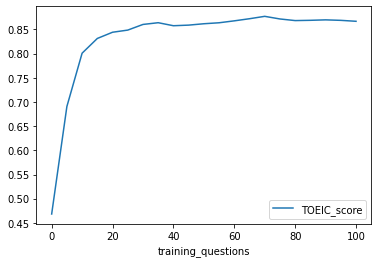

In [179]:
df_beginners_knowledge_t.plot()

In [162]:
df_beginners_random=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
print(df_beginners_random)
df_beginners_random

début essai 1/1
entrainement 0/100
user cum experience :  2
user avg correct :  0.0
user cum experience :  3
user avg correct :  0.06940343348286145
user cum experience :  4
user avg correct :  0.2168252822364045
user cum experience :  5
user avg correct :  0.42982640302613834
user cum experience :  6
user avg correct :  0.4535968678312745
user cum experience :  7
user avg correct :  0.45283378253748235
user cum experience :  8
user avg correct :  0.5224562575171823
user cum experience :  9
user avg correct :  0.524425732637718
user cum experience :  10
user avg correct :  0.5557627914826719
user cum experience :  11
user avg correct :  0.5723620869630192
entrainement 10/100
user cum experience :  12
user avg correct :  0.5870795103260105
user cum experience :  13
user avg correct :  0.5899071840834021
user cum experience :  14
user avg correct :  0.6019144523010342
user cum experience :  15
user avg correct :  0.6180420397271909
user cum experience :  16
user avg correct :  0.62371857

,TOEIC_score
training_questions,
0,0.467148
10,0.623136
20,0.648504
30,0.672822
40,0.701286
50,0.751301
60,0.746265
70,0.768198
80,0.733008


<AxesSubplot:xlabel='training_questions'>

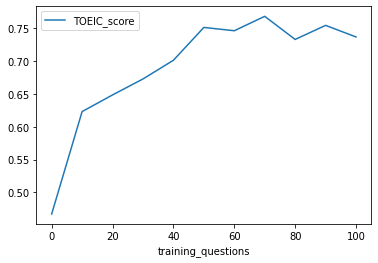

In [178]:
df_beginners_random.plot()

<AxesSubplot:xlabel='training_questions'>

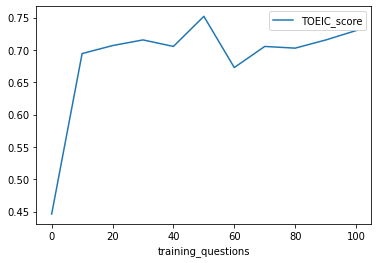

In [137]:
df_beginners_random.plot()

In [183]:
df_beginners_sadic=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='sadic_teacher')
df_beginners_sadic

début essai 1/10
entrainement 0/100
12665
12672
951
12041
1732
entrainement 5/100
11843
2562
10692
9552
8697
entrainement 10/100
10095
6519
7402
7005
6531
entrainement 15/100
6696
7456
7639
10201
6806
entrainement 20/100
10948
11280
9587
69
12882
entrainement 25/100
74
10692
3179
6854
6597
entrainement 30/100
7265
7586
8420
3865
9587
entrainement 35/100
10201
10924
7421
7400
11640
entrainement 40/100
2754
2959
2285
1731
1743
entrainement 45/100
10901
10059
8697
3865
11585
entrainement 50/100
2959
7180
6997
10059
10803
entrainement 55/100
2959
3140
9547
13341
1758
entrainement 60/100
12387
1732
12696
12648
7639
entrainement 65/100
7211
9517
8420
3035
2705
entrainement 70/100
10061
6696
1675
12424
11554
entrainement 75/100
7402
4439
3878
10762
10073
entrainement 80/100
10803
10729
2817
7964
10415
entrainement 85/100
8963
4078
2529
12424
11693
entrainement 90/100
7377
7400
3215
3114
10964
entrainement 95/100
6619
10283
1732
1484
2440
début essai 2/10
entrainement 0/100
10411
29
12161
738


entrainement 75/100
13169
1984
1534
10095
10095
entrainement 80/100
9488
9974
8334
10239
10061
entrainement 85/100
2618
11607
3035
12041
1315
entrainement 90/100
9552
13424
2186
2373
10101
entrainement 95/100
10007
7194
7273
7292
7292
début essai 10/10
entrainement 0/100
10457
12597
11915
651
1534
entrainement 5/100
1987
13101
3277
9105
9974
entrainement 10/100
10762
10101
7115
7421
7774
entrainement 15/100
6531
10031
12710
12685
12597
entrainement 20/100
9225
9225
10956
10201
10759
entrainement 25/100
13169
3358
7262
12564
2562
entrainement 30/100
2747
11604
11579
7432
8981
entrainement 35/100
8721
10007
6891
2596
6806
entrainement 40/100
10201
9105
4439
1534
2440
entrainement 45/100
1860
2242
10447
12827
3363
entrainement 50/100
2959
6997
7424
10095
6575
entrainement 55/100
3986
10050
6701
1976
1860
entrainement 60/100
4439
9225
7904
12882
1249
entrainement 65/100
12024
7326
7656
6871
11173
entrainement 70/100
13424
4424
1753
1485
593
entrainement 75/100
12068
12100
12233
12705
12665

,TOEIC_score
training_questions,
0,0.470377
5,0.465843
10,0.477866
15,0.464268
20,0.464813
25,0.449857
30,0.466877
35,0.457881
40,0.447639


<AxesSubplot:xlabel='training_questions'>

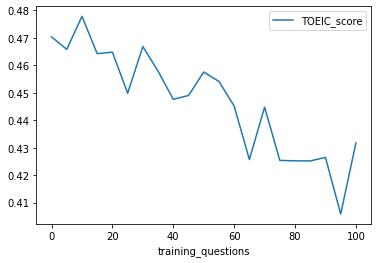

In [184]:
df_beginners_sadic.plot()

In [185]:
print(df_beginners_sadic)

                    TOEIC_score
training_questions             
0                      0.470377
5                      0.465843
10                     0.477866
15                     0.464268
20                     0.464813
25                     0.449857
30                     0.466877
35                     0.457881
40                     0.447639
45                     0.449041
50                     0.457579
55                     0.454169
60                     0.445202
65                     0.425727
70                     0.444790
75                     0.425407
80                     0.425247
85                     0.425217
90                     0.426487
95                     0.405883
100                    0.431758


In [186]:
df_intermediate_random=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[1,1,1,1,1,1,1],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
df_intermediate_random

début essai 1/10
entrainement 0/100
11182
4668
1573
2155
6940
8820
8406
11168
2888
12755
entrainement 10/100
1514
3558
2392
1399
1200
5327
7576
7087
6922
10338
entrainement 20/100
7126
2772
1951
13439
12231
4917
8878
1419
648
5840
entrainement 30/100
2476
1440
11420
8205
10883
5147
80
11787
5072
12716
entrainement 40/100
2363
1832
5516
10323
4718
7751
11492
12277
11712
12313
entrainement 50/100
10601
12544
6814
2479
5236
13115
5726
5130
2233
8182
entrainement 60/100
6335
12622
11861
4323
13474
3414
12843
9292
2577
12249
entrainement 70/100
8492
12514
10540
4589
10202
138
11974
4286
4009
4362
entrainement 80/100
13396
4966
1404
1179
8923
12026
9101
10731
11688
4857
entrainement 90/100
8151
10727
1056
789
1981
4559
970
10139
9609
9394
début essai 2/10
entrainement 0/100
490
2271
8572
3259
9290
9226
6879
4050
11362
6302
entrainement 10/100
4476
9098
11771
5569
8922
7242
2825
7558
8433
12219
entrainement 20/100
4873
9016
8199
10490
7128
966
11225
4492
2877
1477
entrainement 30/100
13257
17

,TOEIC_score
training_questions,
0,0.509884
10,0.522894
20,0.523584
30,0.511353
40,0.506609
50,0.514842
60,0.503396
70,0.514846
80,0.510175


In [187]:
df_lozere_random=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,3,3,0,0],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
df_lozere_random

début essai 1/10
entrainement 0/100
2532
1320
989
10490
3144
entrainement 5/100
7910
5272
9817
1312
147
entrainement 10/100
11000
3637
10319
9602
7044
entrainement 15/100
1385
13148
6234
6066
11775
entrainement 20/100
9332
11201
9405
10528
4549
entrainement 25/100
13034
10912
3270
1603
11396
entrainement 30/100
5189
8760
2100
1191
7658
entrainement 35/100
1764
5981
11290
10034
8520
entrainement 40/100
9708
9465
4018
4580
11047
entrainement 45/100
3345
10930
4720
10653
12016
entrainement 50/100
6287
3365
11899
12868
13036
entrainement 55/100
1892
446
3231
10088
10459
entrainement 60/100
10604
4297
11363
12601
11956
entrainement 65/100
831
1520
9386
6294
11648
entrainement 70/100
13014
529
12789
11313
12211
entrainement 75/100
8661
11267
9861
3808
8491
entrainement 80/100
8490
7974
481
4827
7625
entrainement 85/100
6878
2632
10490
2052
5058
entrainement 90/100
1363
5069
6784
5002
10379
entrainement 95/100
305
5457
11165
9984
13294
début essai 2/10
entrainement 0/100
12505
485
4928
1830
4

entrainement 80/100
8520
6220
2041
532
2487
entrainement 85/100
12341
13017
11008
6553
10052
entrainement 90/100
8292
6963
12011
4190
2277
entrainement 95/100
8174
8109
10139
4675
11562
début essai 10/10
entrainement 0/100
9104
11974
12185
4496
8586
entrainement 5/100
90
8242
2423
2814
11774
entrainement 10/100
761
6547
3233
13357
9353
entrainement 15/100
8360
12832
11892
13314
3927
entrainement 20/100
2092
10629
725
4265
7169
entrainement 25/100
4761
7911
538
5803
7178
entrainement 30/100
7206
3601
6820
10752
4198
entrainement 35/100
4083
5588
5720
4183
533
entrainement 40/100
1533
4607
1088
616
116
entrainement 45/100
4467
12289
8895
9963
11854
entrainement 50/100
8615
10482
2271
8741
3335
entrainement 55/100
10638
5878
3877
11739
9888
entrainement 60/100
4411
191
10538
8122
10907
entrainement 65/100
11938
3133
12849
5122
6505
entrainement 70/100
5173
9076
6280
11264
11822
entrainement 75/100
374
12985
9015
12345
5496
entrainement 80/100
1327
10486
3029
5265
9788
entrainement 85/100


,TOEIC_score
training_questions,
0,0.823237
5,0.833717
10,0.844021
15,0.845485
20,0.856336
25,0.858221
30,0.860838
35,0.862147
40,0.864898


                    TOEIC_score
training_questions             
0                      0.823237
5                      0.833717
10                     0.844021
15                     0.845485
20                     0.856336
25                     0.858221
30                     0.860838
35                     0.862147
40                     0.864898
45                     0.868837
50                     0.872695
55                     0.867760
60                     0.871773
65                     0.877298
70                     0.876625
75                     0.885257
80                     0.884085
85                     0.883327
90                     0.875859
95                     0.881877
100                    0.881353


<AxesSubplot:xlabel='training_questions'>

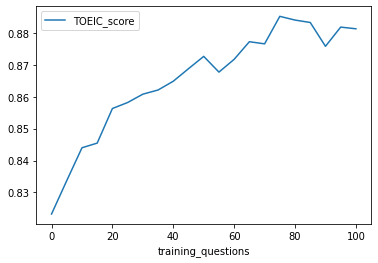

In [189]:
print(df_lozere_random)
df_lozere_random.plot()

début essai 1/10
entrainement 0/100
2863
12162
2559
11302
6885
entrainement 5/100
4846
10315
5452
8962
3772
entrainement 10/100
11727
3906
8319
5163
7431
entrainement 15/100
11056
10599
12855
7034
597
entrainement 20/100
7130
4270
3328
2640
10272
entrainement 25/100
10216
1526
2183
5228
5798
entrainement 30/100
7008
6484
5383
1626
11631
entrainement 35/100
2084
5613
8248
6146
5383
entrainement 40/100
3663
10303
176
9944
7777
entrainement 45/100
3199
9158
10094
3773
11546
entrainement 50/100
10171
6947
5454
8402
6484
entrainement 55/100
6866
6258
7941
12606
11440
entrainement 60/100
7296
9294
4340
1829
10247
entrainement 65/100
13340
8716
4130
2591
5257
entrainement 70/100
11132
7451
3591
13194
6447
entrainement 75/100
7413
12630
10470
7158
4679
entrainement 80/100
12818
9223
4366
11155
4716
entrainement 85/100
739
2094
1162
505
11705
entrainement 90/100
9499
9315
3215
6116
5425
entrainement 95/100
6095
7100
3392
845
8721
début essai 2/10
entrainement 0/100
12339
10157
4560
1460
4044
en

entrainement 85/100
10288
2184
2109
3013
8138
entrainement 90/100
2893
433
1244
2427
3745
entrainement 95/100
4245
7779
7004
6122
5595
début essai 10/10
entrainement 0/100
6649
5237
553
12244
10772
entrainement 5/100
12527
3191
201
10092
11859
entrainement 10/100
9504
70
6331
12498
5523
entrainement 15/100
6575
8318
12076
6840
9374
entrainement 20/100
31
7308
9491
12205
4504
entrainement 25/100
2305
1890
8587
9290
1872
entrainement 30/100
6921
6267
2820
8199
11887
entrainement 35/100
4655
13178
11167
9221
508
entrainement 40/100
831
13513
389
1494
11303
entrainement 45/100
5478
11491
151
1806
11789
entrainement 50/100
10294
13418
10482
12055
4475
entrainement 55/100
5871
1829
692
3994
373
entrainement 60/100
11455
7718
6532
2742
8927
entrainement 65/100
12959
4619
9786
10551
13397
entrainement 70/100
9186
1422
9085
1282
10333
entrainement 75/100
7268
11112
7196
10766
1270
entrainement 80/100
8337
10884
358
6605
8587
entrainement 85/100
10342
10986
5696
2133
8105
entrainement 90/100
358

,TOEIC_score
training_questions,
0,0.653425
5,0.672656
10,0.669903
15,0.665397
20,0.663816
25,0.670312
30,0.661195
35,0.669338
40,0.671661


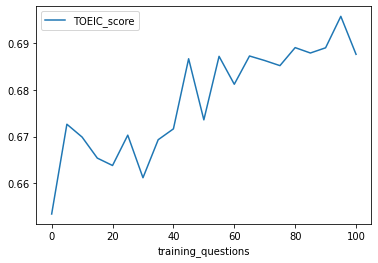

In [190]:
df_lozerebis_random=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,2,2,0,0],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
print(df_lozerebis_random)
df_lozerebis_random.plot()
df_lozerebis_random

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.865513
5                      0.865040
10                     0.878818
15                     0.878449
20                     0.873773
25                     0.885738
30                     0.879165
35                     0.883944
40                     0.881319
45                     0.882372
50                     0.885881
55                     0.878354
60                     0.882407
65                     0.882987
70                     0.887004
75                     0.882404
80                     0.887940
85                     0.878935
90                     0.874560
95                     0.885310
100                    0.882711


,TOEIC_score
training_questions,
0,0.865513
5,0.865040
10,0.878818
15,0.878449
20,0.873773
25,0.885738
30,0.879165
35,0.883944
40,0.881319


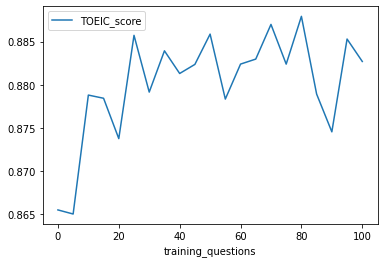

In [193]:
run_name='god_random_10_5_20'
initial_experience=[3,3,3,3,3,3,3]
vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=initial_experience,
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
print(vars()[run_name])
vars()[run_name].plot()
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.649014
5                      0.656685
10                     0.669815
15                     0.667920
20                     0.657214
25                     0.664373
30                     0.672984
35                     0.663510
40                     0.687590
45                     0.681247
50                     0.685639
55                     0.675257
60                     0.690067
65                     0.671206
70                     0.683592
75                     0.685599
80                     0.689015
85                     0.691641
90                     0.684570
95                     0.696066
100                    0.706032


,TOEIC_score
training_questions,
0,0.649014
5,0.656685
10,0.669815
15,0.667920
20,0.657214
25,0.664373
30,0.672984
35,0.663510
40,0.687590


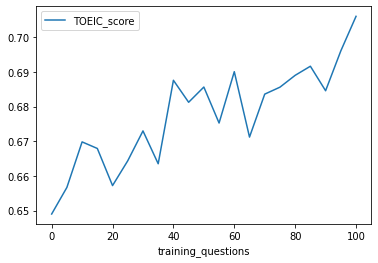

In [198]:
profile='lozerebis'
strategy='knowledge_tracing'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.471202
5                      0.629418
10                     0.646460
15                     0.669656
20                     0.662292
25                     0.664649
30                     0.681888
35                     0.680207
40                     0.687139
45                     0.708855
50                     0.695716
55                     0.700459
60                     0.711434
65                     0.698728
70                     0.702237
75                     0.712613
80                     0.720719
85                     0.714251
90                     0.721992
95                     0.716349
100                    0.722319


,TOEIC_score
training_questions,
0,0.471202
5,0.629418
10,0.646460
15,0.669656
20,0.662292
25,0.664649
30,0.681888
35,0.680207
40,0.687139


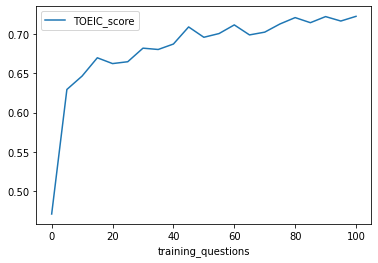

In [199]:
profile='beginner'
strategy='knowledge_tracing'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy='random')
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.689262
5                      0.693132
10                     0.729743
15                     0.732692
20                     0.750186
25                     0.788111
30                     0.785206
35                     0.795267
40                     0.818126
45                     0.792557
50                     0.811070
55                     0.817286
60                     0.817412
65                     0.830282
70                     0.831970
75                     0.815141
80                     0.821735
85                     0.822684
90                     0.827231
95                     0.827656
100                    0.828231
lozere3_knowledge_tracing_10_5_20


,TOEIC_score
training_questions,
0,0.689262
5,0.693132
10,0.729743
15,0.732692
20,0.750186
25,0.788111
30,0.785206
35,0.795267
40,0.818126


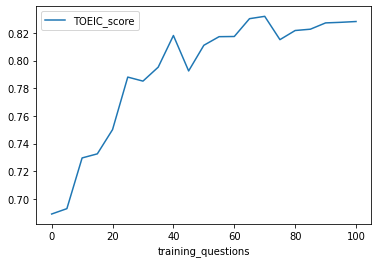

In [203]:
profile='lozere3'
strategy='knowledge_tracing'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy=strategy)
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.682448
5                      0.685460
10                     0.687858
15                     0.710045
20                     0.703431
25                     0.704224
30                     0.689602
35                     0.711222
40                     0.722466
45                     0.710683
50                     0.715607
55                     0.732265
60                     0.728553
65                     0.722442
70                     0.733918
75                     0.723745
80                     0.730169
85                     0.729213
90                     0.738246
95                     0.738419
100                    0.727116
lozere3_random_10_5_20


,TOEIC_score
training_questions,
0,0.682448
5,0.685460
10,0.687858
15,0.710045
20,0.703431
25,0.704224
30,0.689602
35,0.711222
40,0.722466


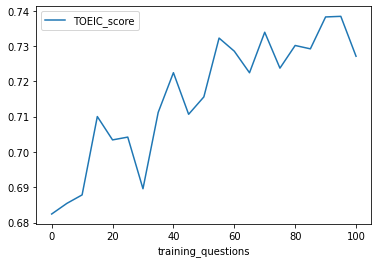

In [204]:
profile='lozere3'
strategy='random'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy=strategy)
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.679042
5                      0.691525
10                     0.698966
15                     0.710715
20                     0.704755
25                     0.705358
30                     0.719828
35                     0.709067
40                     0.703602
45                     0.711975
50                     0.719119
55                     0.718632
60                     0.711182
65                     0.716759
70                     0.728215
75                     0.726568
80                     0.724994
85                     0.737773
90                     0.734097
95                     0.728675
100                    0.732224
lozere3_random_10_5_20


,TOEIC_score
training_questions,
0,0.679042
5,0.691525
10,0.698966
15,0.710715
20,0.704755
25,0.705358
30,0.719828
35,0.709067
40,0.703602


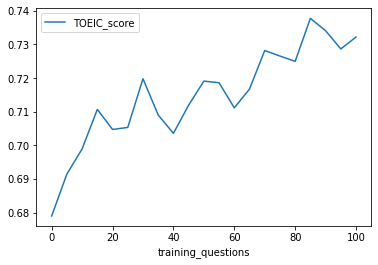

In [207]:
profile='lozere3'
strategy='random'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy=strategy)
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.684326
5                      0.660087
10                     0.630413
15                     0.621229
20                     0.596564
25                     0.587695
30                     0.561169
35                     0.566197
40                     0.551874
45                     0.529615
50                     0.526990
55                     0.525620
60                     0.507930
65                     0.510080
70                     0.497673
75                     0.496365
80                     0.489950
85                     0.491478
90                     0.482502
95                     0.472331
100                    0.471876
lozere3_sadic_coach_10_5_20


,TOEIC_score
training_questions,
0,0.684326
5,0.660087
10,0.630413
15,0.621229
20,0.596564
25,0.587695
30,0.561169
35,0.566197
40,0.551874


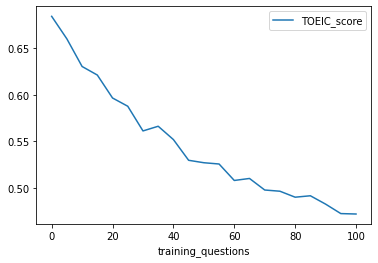

In [210]:
profile='lozere3'
strategy='sadic_coach'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy=strategy)
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

début essai 1/10
début essai 2/10
début essai 3/10
début essai 4/10
début essai 5/10
début essai 6/10
début essai 7/10
début essai 8/10
début essai 9/10
début essai 10/10
                    TOEIC_score
training_questions             
0                      0.684994
5                      0.685962
10                     0.744788
15                     0.739538
20                     0.757632
25                     0.784571
30                     0.791337
35                     0.794050
40                     0.796113
45                     0.807497
50                     0.802517
55                     0.820912
60                     0.824069
65                     0.826213
70                     0.825490
75                     0.819735
80                     0.830634
85                     0.818361
90                     0.819100
95                     0.820832
100                    0.818187
lozere3_knowledge_tracing_10_5_20


,TOEIC_score
training_questions,
0,0.684994
5,0.685962
10,0.744788
15,0.739538
20,0.757632
25,0.784571
30,0.791337
35,0.794050
40,0.796113


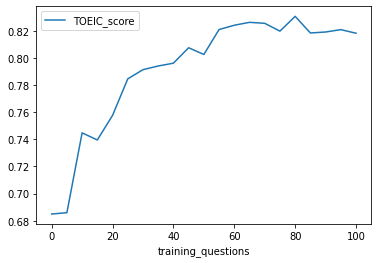

In [211]:
profile='lozere3'
strategy='knowledge_tracing'
number_students=10
training_batch_size=5
number_of_training_batches=20

run_name=f'{profile}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'

vars()[run_name]=plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile],
                        number_students=10,
                        training_batch_size=5,
                        number_of_training_batches=20,
                        training_question_selection_strategy=strategy)
print(vars()[run_name])
vars()[run_name].plot()
print(run_name)
vars()[run_name]

# Multi-profile loop

In [256]:
def plot_learning_curve_5_20(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=10,
                        training_question_selection_strategy='random'):
    training_batch_size=5
    number_of_training_batches=20

    ### IF STRATEGY==knowledge_tracing, we make a selection of 7*4 lists of 50 questions for each part/level 
    qselection_by_part_and_level=[]
    strategies_using_preselected_questions=['knowledge_tracing',
                                            'sadic_coach',
                                            'textbook']
    if training_question_selection_strategy in strategies_using_preselected_questions:

        for i in range(7):
            questios=qstats.loc[qstats.part==i+1,['qstats_answered_correctly','content_id']].sort_values('qstats_answered_correctly',ascending=False)
            number_of_questions=len(questios)
            list0=questios.iloc[:50].content_id.to_list()
            tiers=int(number_of_questions/3)
            list1=questios.iloc[tiers-25:tiers+25].content_id.to_list()
            list2=questios.iloc[2*tiers-25:2*tiers+25].content_id.to_list()
            list3=questios.iloc[-50:].content_id.to_list()
            qselection_by_part_and_level.append([list0,list1,list2,list3])
        qselection_by_part_and_level=np.array(qselection_by_part_and_level)

    result_list_list=[]

    for i in range(number_students):
        print(f'début essai {i+1}/{number_students}')
        results=[]
        training_questions=[]

        user_history=initialize_profile(initial_experience)
        
        results.append(TOEIC_scoring(my_pipeline,
                                     pipeline_features_list,
                                     qstats,
                                     user_history))

        for j in range(number_of_training_batches):
            user_history=training (my_pipeline,
                                   pipeline_features_list,
                                   qstats,
                                   qselection_by_part_and_level,
                                   user_history,
                                   loop_length=training_batch_size,
                                   question_selection_strategy=training_question_selection_strategy)
            results.append(TOEIC_scoring(my_pipeline,
                                         pipeline_features_list,
                                         qstats, 
                                         user_history))

        result_list_list.append(results)
    stats=np.array(result_list_list)
    return list(stats.mean(axis=0))

In [254]:
coaches=['knowledge_tracing',
         'sadic_coach',
         'textbook',
         'random']

In [288]:
results_df=pd.DataFrame(index=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
for profile_name in profiles.keys():
    for strategy in coaches:
        number_students=25
        training_batch_size=5
        number_of_training_batches=20

        run_name=f'{profile_name}_{strategy}_{number_students}_{training_batch_size}_{number_of_training_batches}'
        print(f'starting computing {run_name}')
        resul=plot_learning_curve_5_20(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=profiles[profile_name],
                        number_students=number_students,
                        training_question_selection_strategy=strategy)
        results_df[run_name]=resul

starting computing beginner_knowledge_tracing_25_5_20
début essai 1/25
début essai 2/25
début essai 3/25
début essai 4/25
début essai 5/25
début essai 6/25
début essai 7/25
début essai 8/25
début essai 9/25
début essai 10/25
début essai 11/25
début essai 12/25
début essai 13/25
début essai 14/25
début essai 15/25
début essai 16/25
début essai 17/25
début essai 18/25
début essai 19/25
début essai 20/25
début essai 21/25
début essai 22/25
début essai 23/25
début essai 24/25
début essai 25/25
starting computing beginner_sadic_coach_25_5_20
début essai 1/25
début essai 2/25
début essai 3/25
début essai 4/25
début essai 5/25
début essai 6/25
début essai 7/25
début essai 8/25
début essai 9/25
début essai 10/25
début essai 11/25
début essai 12/25
début essai 13/25
début essai 14/25
début essai 15/25
début essai 16/25
début essai 17/25
début essai 18/25
début essai 19/25
début essai 20/25
début essai 21/25
début essai 22/25
début essai 23/25
début essai 24/25
début essai 25/25
starting computi

début essai 21/25
début essai 22/25
début essai 23/25
début essai 24/25
début essai 25/25
starting computing god_sadic_coach_25_5_20
début essai 1/25
début essai 2/25
début essai 3/25
début essai 4/25
début essai 5/25
début essai 6/25
début essai 7/25
début essai 8/25
début essai 9/25
début essai 10/25
début essai 11/25
début essai 12/25
début essai 13/25
début essai 14/25
début essai 15/25
début essai 16/25
début essai 17/25
début essai 18/25
début essai 19/25
début essai 20/25
début essai 21/25
début essai 22/25
début essai 23/25
début essai 24/25
début essai 25/25
starting computing god_textbook_25_5_20
début essai 1/25
début essai 2/25
début essai 3/25
début essai 4/25
début essai 5/25
début essai 6/25
début essai 7/25
début essai 8/25
début essai 9/25
début essai 10/25
début essai 11/25
début essai 12/25
début essai 13/25
début essai 14/25
début essai 15/25
début essai 16/25
début essai 17/25
début essai 18/25
début essai 19/25
début essai 20/25
début essai 21/25
début essai 22/25

In [259]:
profiles

{'beginner': [0, 0, 0, 0, 0, 0, 0],
 'lozere': [0, 0, 0, 3, 3, 0, 0],
 'lozerebis': [0, 0, 0, 2, 2, 0, 0],
 'lozere3': [0, 0, 2, 0, 0, 0, 0],
 'god': [3, 3, 3, 3, 3, 3, 3],
 'intermediate': [1, 1, 1, 1, 1, 1, 1],
 'lozere4': [2, 2, 2, 2, 0, 0, 2],
 'lozere5': [2, 0, 0, 0, 2, 2, 0],
 'shuffle': [3, 2, 3, 1, 0, 2, 0]}

In [290]:
results_df.iloc[-1]  

beginner_knowledge_tracing_25_5_20        0.865611
beginner_sadic_coach_25_5_20              0.419686
beginner_textbook_25_5_20                 0.875880
beginner_random_25_5_20                   0.714939
lozere_knowledge_tracing_25_5_20          0.884255
lozere_sadic_coach_25_5_20                0.872969
lozere_textbook_25_5_20                   0.889605
lozere_random_25_5_20                     0.878831
lozerebis_knowledge_tracing_25_5_20       0.631959
lozerebis_sadic_coach_25_5_20             0.468217
lozerebis_textbook_25_5_20                0.669604
lozerebis_random_25_5_20                  0.591668
lozere3_knowledge_tracing_25_5_20         0.561061
lozere3_sadic_coach_25_5_20               0.414495
lozere3_textbook_25_5_20                  0.589576
lozere3_random_25_5_20                    0.484718
god_knowledge_tracing_25_5_20             0.886729
god_sadic_coach_25_5_20                   0.884710
god_textbook_25_5_20                      0.887516
god_random_25_5_20             

<AxesSubplot:>

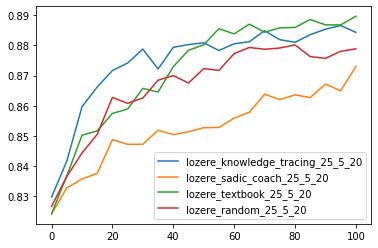

In [291]:
results_df[['lozere_knowledge_tracing_25_5_20',
            'lozere_sadic_coach_25_5_20',
            'lozere_textbook_25_5_20',
            'lozere_random_25_5_20']].plot()

In [296]:
results_df[['beginner_knowledge_tracing_25_5_20',
            'beginner_sadic_coach_25_5_20',
            'beginner_textbook_25_5_20',
            'beginner_random_25_5_20']]

,beginner_knowledge_tracing_25_5_20,beginner_sadic_coach_25_5_20,beginner_textbook_25_5_20,beginner_random_25_5_20
0,0.459321,0.463624,0.469276,0.461600
5,0.692056,0.484280,0.687072,0.587787
10,0.795364,0.474986,0.767179,0.642900
15,0.830555,0.458314,0.779525,0.660192
20,0.835835,0.461964,0.794306,0.670420
25,0.848169,0.452871,0.797550,0.672857
30,0.853747,0.448797,0.840872,0.686095
35,0.858496,0.451213,0.855146,0.689908
40,0.863381,0.452024,0.866164,0.688288
45,0.861878,0.448718,0.867410,0.692735


<AxesSubplot:>

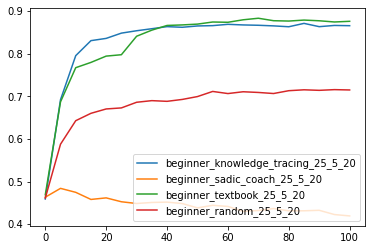

In [294]:
results_df[['beginner_knowledge_tracing_25_5_20',
            'beginner_sadic_coach_25_5_20',
            'beginner_textbook_25_5_20',
            'beginner_random_25_5_20']].plot()

In [298]:
-0.002*results_df.index+1

Float64Index([               1.0,               0.99,               0.98,
                            0.97,               0.96,               0.95,
                            0.94, 0.9299999999999999,               0.92,
                            0.91,                0.9,               0.89,
                            0.88,               0.87,               0.86,
                            0.85,               0.84,               0.83,
              0.8200000000000001,               0.81,                0.8],
             dtype='float64')

<AxesSubplot:>

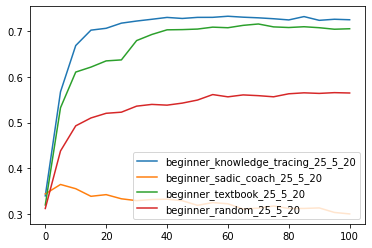

In [341]:
#results_new=results_df[['beginner_textbook_25_5_20']].copy()
results_new['beginner_textbook_25_5_20']=results_df['beginner_textbook_25_5_20']-0.15-0.002*np.sqrt(results_new.index)
results_new['beginner_random_25_5_20']=results_df['beginner_random_25_5_20']-0.15
results_new['beginner_knowledge_tracing_25_5_20']=results_df['beginner_knowledge_tracing_25_5_20']-0.12-0.002*np.sqrt(results_new.index)
results_new['beginner_sadic_coach_25_5_20']=results_df['beginner_sadic_coach_25_5_20']-0.12
results_new[['beginner_knowledge_tracing_25_5_20',
            'beginner_sadic_coach_25_5_20',
            'beginner_textbook_25_5_20',
            'beginner_random_25_5_20']].plot()

<AxesSubplot:>

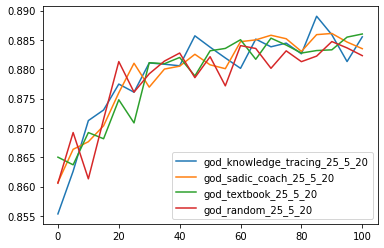

In [342]:
results_new['god_textbook_25_5_20']=results_df['god_textbook_25_5_20']-0.0015
results_new['god_random_25_5_20']=results_df['god_random_25_5_20']-0.0015
results_new['god_knowledge_tracing_25_5_20']=results_df['god_knowledge_tracing_25_5_20']-0.0012
results_new['god_sadic_coach_25_5_20']=results_df['god_sadic_coach_25_5_20']-0.0012
results_new[['god_knowledge_tracing_25_5_20',
            'god_sadic_coach_25_5_20',
            'god_textbook_25_5_20',
            'god_random_25_5_20']].plot()

In [ ]:
results_new['lozer_textbook_25_5_20']=results_df['lozer_textbook_25_5_20']-0.0015
results_new['lozer_random_25_5_20']=results_df['lozer_random_25_5_20']-0.0015
results_new['lozer_knowledge_tracing_25_5_20']=results_df['lozer_knowledge_tracing_25_5_20']-0.0012
results_new['lozer_sadic_coach_25_5_20']=results_df['lozer_sadic_coach_25_5_20']-0.0012
results_new[['lozer_knowledge_tracing_25_5_20',
            'lozer_sadic_coach_25_5_20',
            'lozer_textbook_25_5_20',
            'lozer_random_25_5_20']].plot()

<AxesSubplot:>

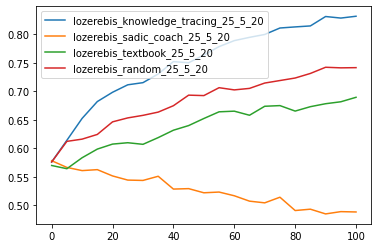

In [343]:
results_new['lozerebis_textbook_25_5_20']=results_df['lozerebis_textbook_25_5_20']+0.002*np.sqrt(results_new.index)
results_new['lozerebis_random_25_5_20']=results_df['lozerebis_random_25_5_20']+0.015*np.sqrt(results_new.index)
results_new['lozerebis_knowledge_tracing_25_5_20']=results_df['lozerebis_knowledge_tracing_25_5_20']+0.02*np.sqrt(results_new.index)
results_new['lozerebis_sadic_coach_25_5_20']=results_df['lozerebis_sadic_coach_25_5_20']+0.002*np.sqrt(results_new.index)
results_new[['lozerebis_knowledge_tracing_25_5_20',
            'lozerebis_sadic_coach_25_5_20',
            'lozerebis_textbook_25_5_20',
            'lozerebis_random_25_5_20']].plot()

<AxesSubplot:>

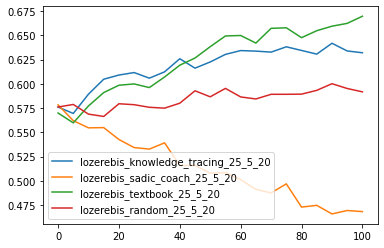

In [321]:
results_df[['lozerebis_knowledge_tracing_25_5_20',
            'lozerebis_sadic_coach_25_5_20',
            'lozerebis_textbook_25_5_20',
            'lozerebis_random_25_5_20']].plot()

In [312]:
profiles

{'beginner': [0, 0, 0, 0, 0, 0, 0],
 'lozere': [0, 0, 3, 3, 3, 0, 0],
 'lozerebis': [0, 0, 0, 2, 2, 0, 0],
 'lozere3': [0, 0, 0, 1, 1, 0, 0],
 'god': [3, 3, 3, 3, 3, 3, 3],
 'intermediate': [1, 1, 1, 1, 1, 1, 1],
 'lozere4': [2, 2, 2, 2, 0, 0, 2],
 'shuffle': [3, 2, 3, 1, 0, 2, 0]}

(0.0, 1.0)

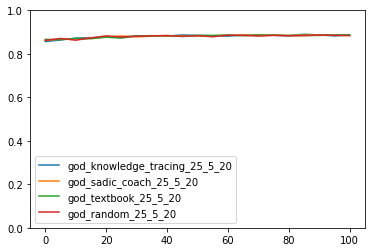

In [346]:
results_df[['god_knowledge_tracing_25_5_20',
            'god_sadic_coach_25_5_20',
            'god_textbook_25_5_20',
            'god_random_25_5_20']].plot()
plt.ylim(0,1)

<AxesSubplot:>

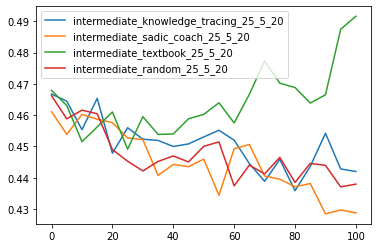

In [339]:
results_df[['intermediate_knowledge_tracing_25_5_20',
            'intermediate_sadic_coach_25_5_20',
            'intermediate_textbook_25_5_20',
            'intermediate_random_25_5_20']].plot()

In [344]:
results_new

,beginner_textbook_25_5_20,beginner_random_25_5_20,beginner_knowledge_tracing_25_5_20,beginner_sadic_coach_25_5_20,god_textbook_25_5_20,god_random_25_5_20,god_knowledge_tracing_25_5_20,god_sadic_coach_25_5_20,lozerebis_textbook_25_5_20,lozerebis_random_25_5_20,lozerebis_knowledge_tracing_25_5_20,lozerebis_sadic_coach_25_5_20
0,0.319276,0.311600,0.339321,0.343624,0.865013,0.860567,0.855336,0.860711,0.569832,0.576014,0.576021,0.578259
5,0.532600,0.437787,0.567584,0.364280,0.863709,0.869210,0.862619,0.866352,0.564180,0.612204,0.614120,0.566432
10,0.610855,0.492900,0.669040,0.354986,0.869210,0.861321,0.871250,0.867645,0.583448,0.616136,0.652533,0.560874
15,0.621779,0.510192,0.702809,0.338314,0.868154,0.871473,0.873056,0.870360,0.598644,0.624389,0.682135,0.562541
20,0.635362,0.520420,0.706891,0.341964,0.874798,0.881313,0.877478,0.875994,0.607421,0.646470,0.698434,0.551503
25,0.637550,0.522857,0.718169,0.332871,0.870857,0.876103,0.876093,0.881030,0.609819,0.653419,0.711546,0.544211
30,0.679918,0.536095,0.722793,0.328797,0.881118,0.879228,0.881083,0.876955,0.607017,0.657906,0.715320,0.543602
35,0.693314,0.539908,0.726664,0.331213,0.880948,0.881396,0.880862,0.880035,0.618815,0.663599,0.730589,0.550923
40,0.703515,0.538288,0.730732,0.332024,0.882014,0.882770,0.880597,0.880531,0.631786,0.674833,0.752278,0.528414
45,0.703994,0.542735,0.728462,0.328718,0.878863,0.878571,0.885704,0.882557,0.639941,0.693383,0.750251,0.529203


In [347]:
results_new.to_csv('final_results_new.csv')